In [15]:
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM, BSREM
from pytomography.priors import RelativeDifferencePrior
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.io.PET import clinical
from pytomography.io.PET import gate, shared

In [16]:
scanner_name = 'discovery_MI'
info = clinical.get_detector_info(scanner_name)

In [17]:
# Get listmode events
detector_ids = clinical.get_detector_ids_hdf5(r"D:\Datasets\dmi_nema_lm\LIST0000.BLF", scanner_name)
# Get scatter/random correction term at each event
additive_term = clinical.get_additive_term_hdf5(r"D:\Datasets\dmi_nema_lm\corrections.h5")
# Get multiplicative weights (attenuation/normalization) at each event
weights = clinical.get_weights_hdf5(r"D:\Datasets\dmi_nema_lm\corrections.h5")
# Get ALL valid detector-pairs and corresponding multiplicative weights
detector_ids_sensitivity, weights_sensitivity = clinical.get_sensitivity_ids_and_weights_hdf5(r"D:\Datasets\dmi_nema_lm\corrections.h5", scanner_name)

In [18]:
# Display the first 5 listmode events
print("Listmode Events (first 5):")
print(detector_ids[:5])

Listmode Events (first 5):
tensor([[  898,  3334,    11],
        [  816, 16375,    18],
        [ 1073, 18816,    14],
        [ 1529, 13781,    13],
        [ 1537, 18663,    14]], dtype=torch.int32)


In [19]:
# Define object space reconstruction matrix
object_meta = ObjectMeta(
    dr=(2.78,2.78,2.78), #mm
    shape=(192,192,71) #voxels
)
# Get time-of-flight metadata and define projection space metadata
tof_meta = clinical.get_tof_meta(scanner_name)
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    tof_meta=None,
    detector_ids_sensitivity=detector_ids_sensitivity,
    weights_sensitivity=weights_sensitivity
    )

In [20]:
psf_transform = GaussianFilter(4.5) # 4.5mm gaussian psf
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [psf_transform],
    N_splits=8,
)

In [21]:
psf_transform = GaussianFilter(4.5) # 4.5mm gaussian psf
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [psf_transform],
    N_splits=8,
)

In [22]:
likelihood = PoissonLogLikelihood(
    system_matrix,
    additive_term=additive_term/weights,
)

In [23]:
recon_algorithm = OSEM(likelihood)
recon_OSEM = recon_algorithm(n_iters=2, n_subsets=34)

In [24]:
# This is probably very similar to "Q.Clear" is ;)
# prior = RelativeDifferencePrior(beta=25, gamma=2)
# recon_algorithm = BSREM(likelihood, prior=prior)
# recon_BSREM = recon_algorithm(n_iters=20, n_subsets=34)

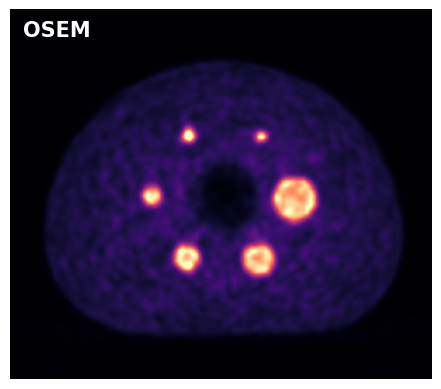

In [25]:
# fig, ax = plt.subplots(1,2,figsize=(5.5,3), gridspec_kw={'wspace': 0.0})
# plt.subplot(121)
plt.imshow(recon_OSEM[:,:,20].T.cpu(), cmap='magma', interpolation='gaussian', vmax=0.5)
plt.axis('off')
plt.text(0.03, 0.97, 'OSEM', color='white', fontsize=15, fontweight='bold', transform=plt.gca().transAxes, ha='left', va='top')
plt.xlim(35,157)
plt.ylim(45,152)
# plt.subplot(122)
# plt.imshow(recon_BSREM[:,:,20].T.cpu(), cmap='magma', interpolation='gaussian', vmax=0.5)
# plt.axis('off')
# plt.text(0.03, 0.97, 'BSREM (RDP)', color='white', fontsize=15, fontweight='bold', transform=plt.gca().transAxes, ha='left', va='top')
# plt.xlim(35,157)
# plt.ylim(45,152)
# fig.tight_layout()
plt.show()

In [26]:
sinogram_randoms_true = gate.listmode_to_sinogram(detector_ids, info)

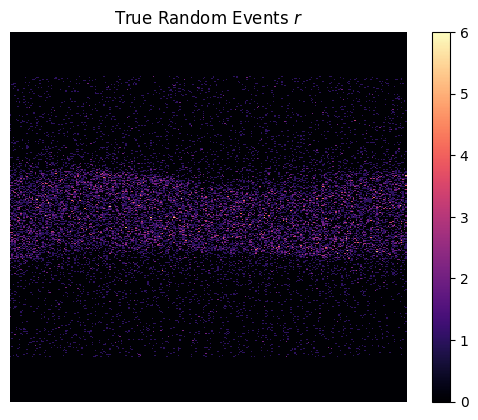

In [40]:
# fig = plt.figure(figsize=(10,3))
# plt.subplot(211)
plt.pcolormesh(sinogram_randoms_true[:,:,795].T, cmap='magma')
plt.title('True Random Events $r$')
plt.axis('off')
plt.colorbar()
# plt.subplot(212)
# plt.pcolormesh(sinogram_randoms_estimate[0,:,:64].T, cmap='magma')
# plt.title(r'Estimated Random Events $\bar{r}$')
# plt.axis('off')
# plt.colorbar()
# fig.tight_layout()
plt.show()

# Delete to save memory
# del(sinogram_randoms_true)

In [28]:
# detector_ids_2 = gate.sinogram_to_listmode(sinogram_randoms_true, info=info)